# Import and misc

In [1]:
# Instal latest torch and torchaudio

In [2]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [3]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [4]:
# !wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
# !mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

In [5]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [6]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [7]:
dataset.csv.sample(5)

,path,keyword,label
5125,speech_commands/cat/96cd0255_nohash_0.wav,cat,0
26291,speech_commands/stop/f4504600_nohash_0.wav,stop,0
48157,speech_commands/house/93f30cc4_nohash_1.wav,house,0
62051,speech_commands/off/2dce72b3_nohash_0.wav,off,0
27011,speech_commands/three/c1d39ce8_nohash_6.wav,three,0


### Augmentations

In [8]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [9]:
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [10]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [11]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [12]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [13]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [14]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [15]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [16]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [17]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [18]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [19]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [20]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [21]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [22]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [23]:
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 32, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=32, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=32, out_features=2, bias=True)
)


In [24]:
sum([p.numel() for p in model.parameters()])

25387

In [25]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/egoriya/miniconda/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/egoriya/miniconda/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'SpeechCommandDataset' on <module '__main__' (built-in)>


In [ ]:
history

### Reproduce

In [ ]:
history = defaultdict(list)
config = TaskConfig(hidden_size=32)
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history

In [ ]:
from run import run

In [ ]:
from kws.config import UncompressedConfig

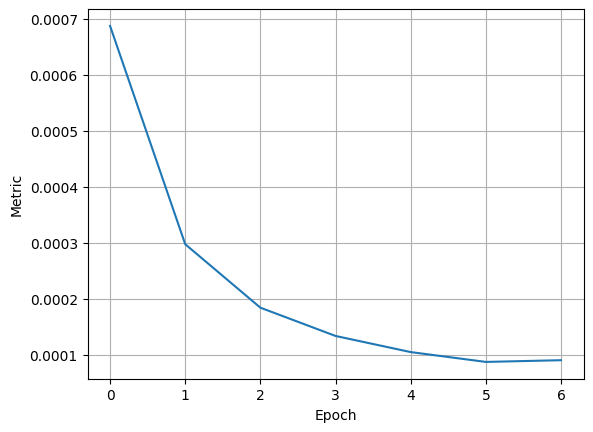

END OF EPOCH 6


  4%|▍         | 16/405 [00:01<00:41,  9.26it/s]


KeyboardInterrupt: 

In [ ]:
run(UncompressedConfig)

In [ ]:
from kws.models import StreamCRNN
from kws.data_utils import SpeechCommandDataset

In [ ]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=[UncompressedConfig().keyword, 'dog', 'nine']
)

In [ ]:
dataset.csv

,path,keyword,label
0,speech_commands/right/988e2f9a_nohash_0.wav,right,0
1,speech_commands/right/1eddce1d_nohash_3.wav,right,0
2,speech_commands/right/93ec8b84_nohash_0.wav,right,0
3,speech_commands/right/6272b231_nohash_1.wav,right,0
4,speech_commands/right/439c84f4_nohash_1.wav,right,0
...,...,...,...
64716,speech_commands/four/93f30cc4_nohash_1.wav,four,0
64717,speech_commands/four/0c40e715_nohash_0.wav,four,0
64718,speech_commands/four/238c112c_nohash_0.wav,four,0
64719,speech_commands/four/173ae793_nohash_1.wav,four,0


In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import matplotlib.pyplot as plt

import tqdm
from pathlib import Path
from IPython import display

import pandas as pd

import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from kws.augmentations import LogMelspec

from kws.config import UncompressedConfig
from kws.models import StreamCRNN

In [2]:
def visualize_audio(wav: torch.Tensor, sr: int = 22050):
    if wav.dim() == 2:
        wav = wav.mean(dim=0)
    
    plt.figure(figsize=(14, 6))
    plt.plot(wav, alpha=0.7, c="green")
    plt.xlabel("Time", size=16)
    plt.ylabel("Amplitude", size=16)
    plt.show()
    
    display.display(display.Audio(wav, rate=sr))

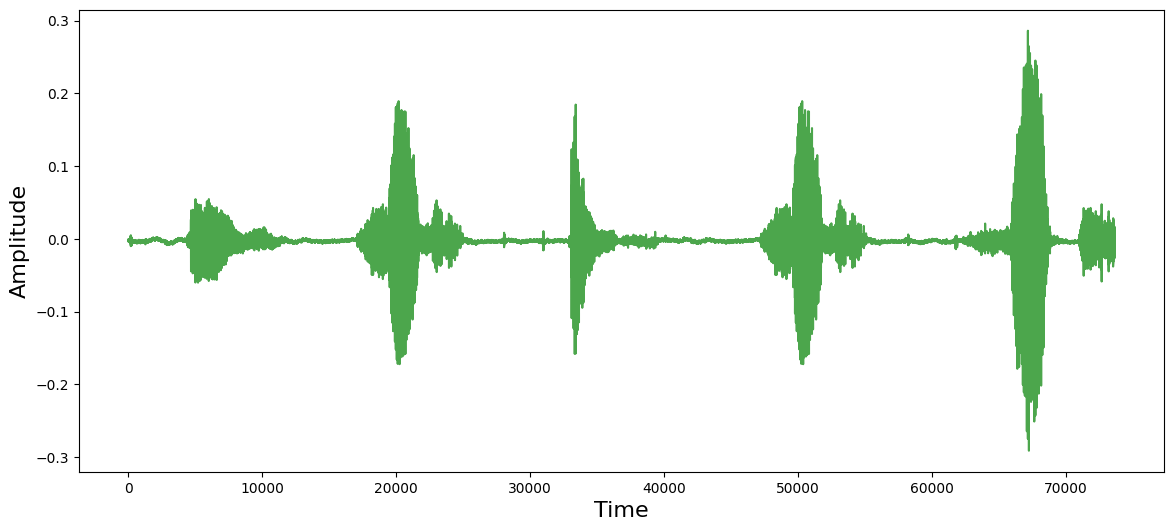

In [52]:
CURRENT_DIR = Path().absolute().resolve()

words = [
    "on", "sheila", "off", "nine", "sheila", "six"
]

audio_overall = torch.Tensor([])

for word in words:
    try:
        audio_path = CURRENT_DIR / f"speech_commands/{word}/" \
                                    "004ae714_nohash_0.wav"
        audio, sr = torchaudio.load(audio_path)
    except RuntimeError:
        continue
    audio_overall = torch.cat((audio_overall, audio), dim=-1)
visualize_audio(audio_overall, 16000)

In [54]:

def plot_audio_inference(streaming_model, audio, config):
    history = []

    for T in range(100, audio.size(-1) + 1, 100):
        window = audio[:, T-100:T]
        probs = streaming_model.process(window.to(config.device))
        history.append(probs[0][1])

    plt.plot(history)
    plt.title("Probability of a keyword", loc="left")
    plt.xlabel("Frame")
    plt.ylabel("Probability")

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
from kws.config import UncompressedConfig
from kws.models import StreamCRNN

In [50]:
import torch
import torch.nn.functional as F
from kws.models import CRNN
from kws.augmentations import LogMelspec

class StreamCRNN(CRNN):
    '''
        Streaming version of CRNN.
    '''

    def __init__(self, config):
        super().__init__(config)

        self.mel_processor = LogMelspec(False, config)
        self.raw_cache = torch.Tensor([])
        self.max_window_length = config.max_window_length
        self.streaming_step_size = config.streaming_step_size
        self.prev_hidden = None
        self.prev_prob = torch.zeros(1, 2)
        self.processed_steps = 0

    @torch.no_grad()
    def process(self, raw_audio: torch.Tensor):
        self.raw_cache = torch.cat([self.raw_cache, raw_audio], dim=-1)[:, -self.max_window_length:]
        self.processed_steps += raw_audio.size(-1)

        if self.processed_steps >= self.streaming_step_size:
            self.processed_steps = 0
            melspec = self.mel_processor(self.raw_cache)
            logits, self.prev_hidden = super().forward(melspec, hiddens=self.prev_hidden)
            self.prev_prob = F.softmax(logits, dim=-1)

        return self.prev_prob

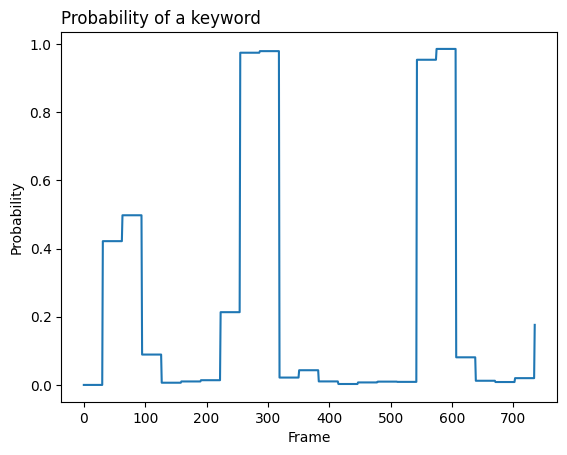

In [55]:
streaming_config = UncompressedConfig()
streaming_config.max_window_length = 8000
streaming_config.streaming_step_size = 3200
streaming_model = StreamCRNN(streaming_config).to(streaming_config.device)
streaming_model.load_state_dict(torch.load("normal_model_5.pth"))

streaming_model.eval()

plot_audio_inference(streaming_model, audio_overall, streaming_config)

In [14]:
torch.cat([torch.Tensor([]), torch.zeros(10, 1)])

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])

In [ ]:
streaming_config = UncompressedConfig()

streaming_model = StreamCRNN(streaming_config).to(streaming_config.device)
streaming_model.load_state_dict(torch.load("baseline_model.pth"))

streaming_model.eval()
# streaming_model.streaming_mode = True
streaming_model.config.max_window_length = 100
streaming_config.streaming_step_size = 1
streaming_config.sample_rate = 16000
streaming_melspec = LogMelspec(is_train=False, config=streaming_config)

probs_history = defaultdict(list)
for obj, label, path in my_loader:
    streaming_model.set_buffer()

    obj, label = obj.to(streaming_config.device), label.to(streaming_config.device)
    obj = obj[:, 1::3]  # sample rate 16000 from 48000
    batch = streaming_melspec(obj)

    for i in range(0, batch.size()[-1], streaming_config.streaming_step_size):
        chunk = batch[:, :, i : i + streaming_config.streaming_step_size]

        output = streaming_model(chunk)
        if output is not None:
            probs = F.softmax(output, dim=-1)

            argmax_probs = torch.argmax(probs, dim=-1)
            probs_history[path[0]].append(probs[:, 1].cpu().item())

    streaming_model.flush()

streaming_model.streaming_mode = False